# **Visualizing Weights in a Neural Network**

This Code is to train a model using Keras and then visualizing the weights in the neural network. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
base_add = os.path.join('..', 'input')
# Any results you write to the current directory are saved as output.

['hmnist_28_28_RGB.csv', 'hmnist_28_28_L.csv', 'ham10000_images_part_2', 'ham10000_images_part_1', 'hmnist_8_8_RGB.csv', 'HAM10000_metadata.csv', 'hmnist_8_8_L.csv']


## Importing essential libraries

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
%matplotlib inline
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [3]:
image_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_add, '*', '*.jpg'))}
lesion_type_dict = {'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'}
df = pd.read_csv(os.path.join(base_add, 'HAM10000_metadata.csv'))

In [4]:
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['path'] = df['image_id'].map(image_path_dict.get)
df['dx_code'] = pd.Categorical(df['dx']).codes
df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,cell_type,path,dx_code
9496,HAM_0003968,ISIC_0033495,nv,consensus,35.0,female,back,Melanocytic nevi,../input/ham10000_images_part_2/ISIC_0033495.jpg,5
2252,HAM_0006899,ISIC_0025128,mel,histo,80.0,female,lower extremity,Melanoma,../input/ham10000_images_part_1/ISIC_0025128.jpg,4
6420,HAM_0003896,ISIC_0030952,nv,follow_up,35.0,male,abdomen,Melanocytic nevi,../input/ham10000_images_part_2/ISIC_0030952.jpg,5


In [5]:
df['age'].fillna(df['age'].mean(), inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             10015 non-null float64
sex             10015 non-null object
localization    10015 non-null object
cell_type       10015 non-null object
path            10015 non-null object
dx_code         10015 non-null int8
dtypes: float64(1), int8(1), object(8)
memory usage: 714.0+ KB


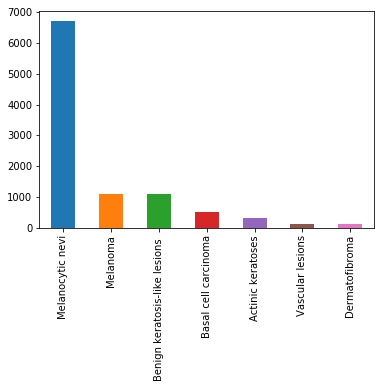

In [6]:
df['cell_type'].value_counts().plot(kind = 'bar')

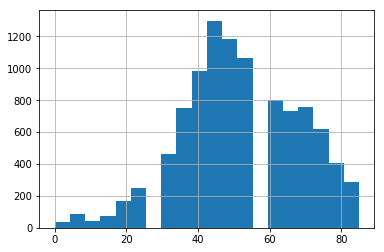

In [7]:
df['age'].hist(bins = 20)

In [8]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100, 75))))

In [9]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    10015
Name: image, dtype: int64

In [10]:
feats = df.drop(['dx_code'], axis = 1)
target = df['dx_code']

In [11]:
x_train, x_test, y_train, y_test = train_test_split(feats, target, test_size = 0.2)

In [12]:
# Normalization
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [13]:
# Label Encodeing
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [14]:
# Reshape images in 3 dimensions
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))

### Creating model of Layers

In [15]:
# Set CNN model
# Our system of layers => [[Conv2D -> relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense
# -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'Same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 75, 100, 32)       896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 100, 32)       9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 50, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 37, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 25, 64)        0         
__________

In [16]:
# Define the optimizer
optimizer = Adam(lr = .001, beta_1 = .9, beta_2 = .999, epsilon = None, decay = .0, amsgrad = False)

In [17]:
# Compile the model
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [18]:
# Set learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, 
                                           factor = 0.5, min_lr = 0.00001)

In [19]:
# Data Augmentation
datagen = ImageDataGenerator(featurewise_center = False, samplewise_center = False,
                            featurewise_std_normalization = False, samplewise_std_normalization = False, 
                            zca_whitening = False, rotation_range = 10, zoom_range = 0.1, 
                            width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = False, 
                            vertical_flip = False)
datagen.fit(x_train)

### Fitting the Model

In [20]:
# Fit the model
# epochs = 50 # Accuracy of 0.7682
epochs = 25
batch_size = 10
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), 
                             epochs = epochs, verbose = 1, steps_per_epoch = x_train.shape[0] // batch_size,
                             callbacks = [learning_rate_reduction])

Epoch 1/25
801/801 [==============================] - 25s 31ms/step - loss: 1.0140 - acc: 0.6642
Epoch 2/25
  7/801 [..............................] - ETA: 19s - loss: 0.8359 - acc: 0.7000

/opt/conda/lib/python3.6/site-packages/keras/callbacks.py:1109: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


801/801 [==============================] - 20s 25ms/step - loss: 0.9196 - acc: 0.6709
Epoch 3/25
801/801 [==============================] - 20s 25ms/step - loss: 0.8876 - acc: 0.6775
Epoch 4/25
801/801 [==============================] - 20s 25ms/step - loss: 0.8603 - acc: 0.6866
Epoch 5/25
801/801 [==============================] - 20s 25ms/step - loss: 0.8357 - acc: 0.6931
Epoch 6/25
801/801 [==============================] - 20s 25ms/step - loss: 0.8333 - acc: 0.6929
Epoch 7/25
801/801 [==============================] - 20s 25ms/step - loss: 0.8012 - acc: 0.7064
Epoch 8/25
801/801 [==============================] - 20s 25ms/step - loss: 0.7984 - acc: 0.7076
Epoch 9/25
801/801 [==============================] - 20s 25ms/step - loss: 0.7785 - acc: 0.7164
Epoch 10/25
801/801 [==============================] - 20s 25ms/step - loss: 0.7749 - acc: 0.7165
Epoch 11/25
801/801 [==============================] - 20s 25ms/step - loss: 0.7678 - acc: 0.7169
Epoch 12/25
801/801 [==================

In [21]:
from matplotlib import figure

In [22]:
def plot_weight_image(layer, x, y):
    weights = model.layers[layer].get_weights()
    fig = plt.figure()
    for j in range(len(weights[0])):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(weights[0][j][0], cmap = plt.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

In [23]:
a = model.layers[0].get_weights()
print(a[0][:, :, :, 0])
print("*"*40)
print(a[0][:, :, :, 1])
a[0].shape

[[[-2.8900404e-02  1.3593194e-01  3.5204716e-02]
  [-2.0115936e-02 -5.5724226e-02  2.7227559e-04]
  [-1.4562674e-01 -3.4424834e-02  6.7236826e-02]]

 [[-2.2601959e-01 -8.2309088e-03  1.6767749e-01]
  [-5.8721740e-02  1.5585414e-02  1.7444366e-01]
  [-1.0679446e-01 -4.3124463e-02  1.8256445e-01]]

 [[-5.5422172e-02  4.9185079e-02  2.4140106e-01]
  [-4.4556390e-02  2.5027502e-02  1.0815277e-01]
  [-3.3505583e-01 -1.2938271e-01  2.3044953e-02]]]
****************************************
[[[-0.12482049 -0.12398676  0.12780525]
  [-0.16014296  0.08461332  0.01659511]
  [-0.32271823 -0.15565911  0.13523762]]

 [[ 0.15772372  0.02287562 -0.07914299]
  [-0.08210208 -0.05587453  0.10982145]
  [ 0.16116509  0.01561329 -0.06394925]]

 [[-0.00221225 -0.16821694  0.1268907 ]
  [ 0.1054718   0.00342105  0.15779196]
  [ 0.05146346  0.10416764 -0.07664261]]]


(3, 3, 3, 32)

### Main Function to create and save image of weight.

In [24]:
np.random.seed(12345)
def save_image(layer):
    a = model.layers[layer].get_weights()
    for i in range(100):
        for j in range(100):
            try:
                grid = a[0][:, :, i, j]
                img = plt.imshow(grid, interpolation = 'spline16', cmap = 'plasma')
                plt.axis('off')
                plt.tight_layout()
                plt.savefig("test{} {}-{}.jpg".format(layer, i , j))
#                 Image.open("test0 1-12.jpg").resize((600, 600))
                
#                 print("Layer no.:", layer)
#                 print("Image no.:", i, j)
    #           plt.imsave("Pic{}.jpg".format(i))
#                 plt.show()
            except:
                break

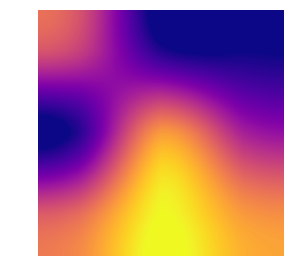

In [25]:
# We are creating these images for weights of only 1st covolutional layer now, 
# all of them would take a lot more time. 
layers = [0]
# , 1, 4, 5]
for layer in layers:
    save_image(layer)